# Healthcare Insurance Expenses - Linear Regression Analysis

## Overview
This notebook presents a comprehensive linear regression analysis on healthcare insurance expense data. The analysis includes data preprocessing, model training, evaluation, and detailed diagnostics.

---

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

# Configure visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Data Loading & Initial Exploration

In [2]:
# Load the dataset
df = pd.read_csv("contents/insurance.csv")

# Display first few rows
print("Dataset Overview - First 5 Rows:")
print(df.head())

Dataset Overview - First 5 Rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


### Dataset Information

In [4]:
# Display dataset information
print("Dataset Structure and Data Types:")
df.info()

Dataset Structure and Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# Display statistical summary
print("Statistical Summary:")
print(df.describe())

Statistical Summary:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [ ]:
# Check dataset dimensions and missing values
print(f"Dataset Shape: {df.shape}")
print(f"\nMissing Values:\n{df.isna().sum()}")

(1338, 7)

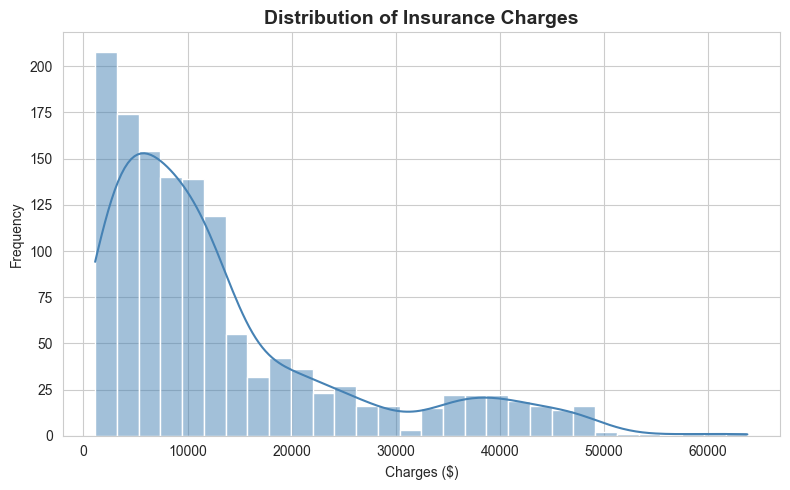

In [6]:
# Visualize the target variable distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['charges'], kde=True, bins=30, color='steelblue')
plt.title("Distribution of Insurance Charges", fontsize=14, fontweight='bold')
plt.xlabel("Charges ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

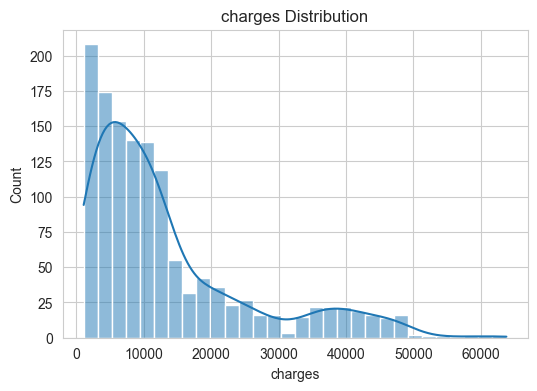

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(df['charges'], kde=True)
plt.title("charges Distribution")
plt.show()

## 2. Data Preprocessing

### Feature Engineering & Encoding

In [ ]:
# Note: Outlier removal is commented out for model robustness
# If needed, uncomment the following code:
# q1 = df['charges'].quantile(q=0.25)
# q3 = df['charges'].quantile(q=0.75)
# iqr = q3 - q1
# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr
# df = df[(df['charges'] >= lower_bound) & (df['charges'] <= upper_bound)]

In [8]:
# Separate features and target variable
X = df.drop('charges', axis=1)
y = df['charges']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1338, 6)
Target shape: (1338,)


In [9]:
# Encode categorical variables
# Binary encoding for 'sex' and 'smoker'
X['sex'] = X['sex'].map({'male': 1, 'female': 0})
X['smoker'] = X['smoker'].map({'yes': 1, 'no': 0})

# One-hot encoding for 'region'
X = pd.get_dummies(X, columns=['region'], drop_first=True)

print("Encoded Features:")
print(X.head())

Encoded Features:
   age  sex     bmi  children  smoker  region_northwest  region_southeast  \
0   19    0  27.900         0       1             False             False   
1   18    1  33.770         1       0             False              True   
2   28    1  33.000         3       0             False              True   
3   33    1  22.705         0       0              True             False   
4   32    1  28.880         0       0              True             False   

   region_southwest  
0              True  
1             False  
2             False  
3             False  
4             False  


In [10]:
# Train-test split (80-20 split with random state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1070
Test set size: 268


In [11]:
# Feature scaling using StandardScaler for numerical columns
scaler = StandardScaler()
numerical_features = ['age', 'bmi', 'children']

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("Features standardized successfully")

Features standardized successfully


In [12]:
# Display sample of preprocessed test features
print("Preprocessed Test Features (first 5 rows):")
print(X_test.head())

Preprocessed Test Features (first 5 rows):
           age  sex       bmi  children  smoker  region_northwest  \
764   0.401140    0 -0.891539  0.734336       0             False   
887  -0.238638    0 -0.089461 -0.911192       0              True   
890   1.751782    0 -0.608453 -0.911192       1              True   
1293  0.472227    1 -0.797177  1.557100       0              True   
259  -1.447107    1  0.225079 -0.911192       1              True   

      region_southeast  region_southwest  
764              False             False  
887              False             False  
890              False             False  
1293             False             False  
259              False             False  


## 3. Model Training

In [14]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

print("Linear Regression model trained successfully")
print(f"Number of features: {model.coef_.shape[0]}")

Linear Regression model trained successfully
Number of features: 8


## 4. Predictions & Model Evaluation

In [15]:
# Make predictions on test set
y_pred = model.predict(X_test)

print("Sample Predictions (first 10):")
print(y_pred[:10])

Sample Predictions (first 10):
[ 8969.55027444  7068.74744287 36858.41091155  9454.67850053
 26973.17345656 10864.11316424   170.28084136 16903.45028662
  1092.43093614 11218.34318352]


### Performance Metrics

In [16]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"Mean Absolute Error (MAE):        ${mae:,.2f}")
print(f"Mean Squared Error (MSE):         ${mse:,.2f}")
print(f"Root Mean Squared Error (RMSE):   ${rmse:,.2f}")
print(f"R² Score:                         {r2:.4f}")
print("=" * 60)

MODEL PERFORMANCE METRICS
Mean Absolute Error (MAE):        $4,181.19
Mean Squared Error (MSE):         $33,596,915.85
Root Mean Squared Error (RMSE):   $5,796.28
R² Score:                         0.7836


## 5. Model Diagnostics & Visualization

### Residual Analysis

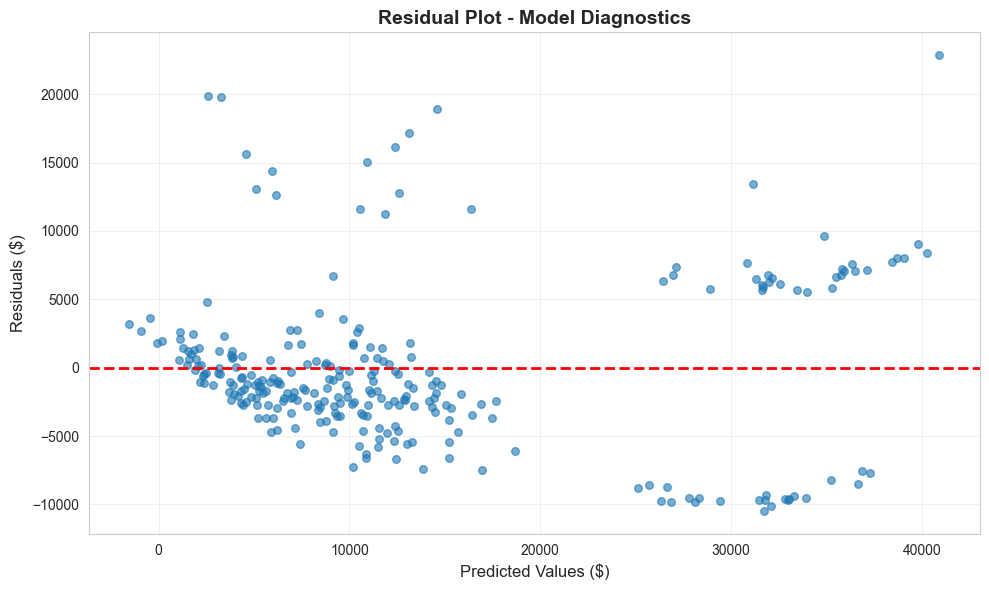

In [17]:
# Calculate residuals
residuals = y_test - y_pred

# Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, s=30)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Predicted Values ($)", fontsize=12)
plt.ylabel("Residuals ($)", fontsize=12)
plt.title("Residual Plot - Model Diagnostics", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

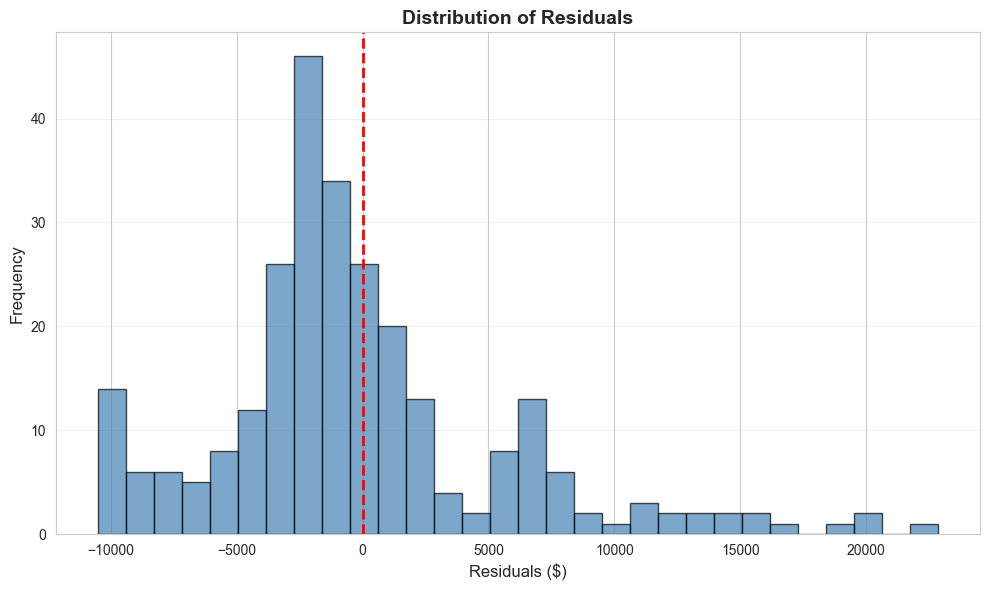

Residuals Mean: $-219.24
Residuals Std Dev: $5802.97


In [18]:
# Residual Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Residuals ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Residuals", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Residuals Mean: ${residuals.mean():.2f}")
print(f"Residuals Std Dev: ${residuals.std():.2f}")

### Learning Curve Analysis

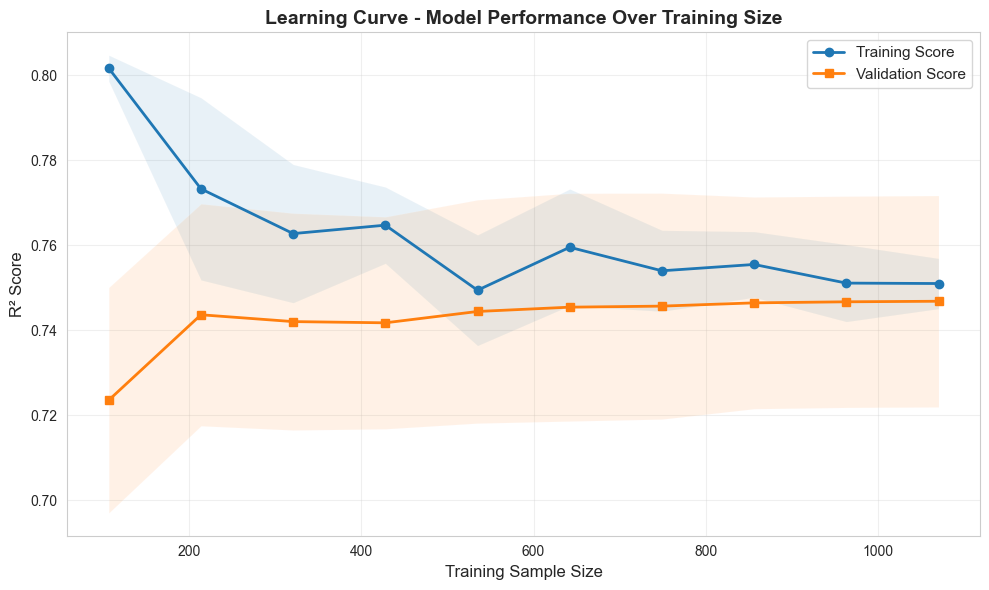

In [19]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation Score', marker='s', linewidth=2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Sample Size", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("Learning Curve - Model Performance Over Training Size", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

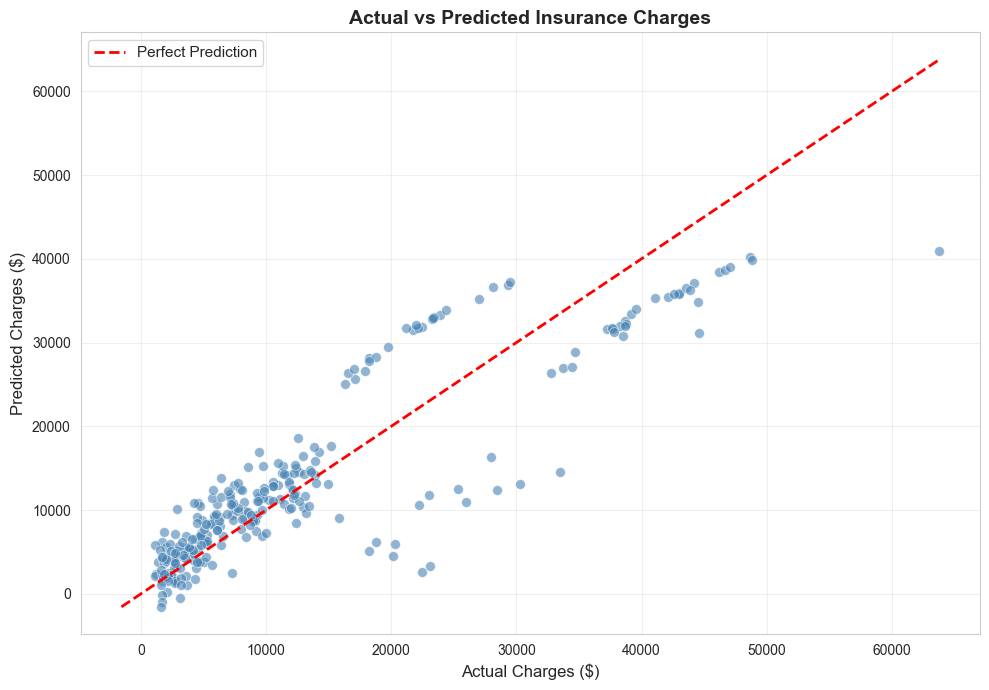

In [20]:
# Actual vs Predicted Comparison
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=50, color='steelblue')

# Add perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual Charges ($)", fontsize=12)
plt.ylabel("Predicted Charges ($)", fontsize=12)
plt.title("Actual vs Predicted Insurance Charges", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()